# Sweep over `train_frames` and `losses_to_use`

In [1]:
import hydra
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
from omegaconf import DictConfig

from lightning_pose.utils.io import return_absolute_data_paths
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.losses.losses import PCALoss

import sys
sys.path.append('/home/jovyan/tracking-diagnostics')
from diagnostics.handler import ModelHandler
from diagnostics.io import get_base_config, get_keypoint_names

In [2]:
# %% get config
dataset_name = "rick-configs-1"
base_config_dir = "/home/jovyan/rick-configs-1"
base_save_dir = "/home/jovyan/"
cfg = get_base_config(config_dir=base_config_dir, config_name="config")

In [3]:

# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

Start by looping over `train_frames` and individual `losses_to_use`. Later build in complication.

In [17]:
save_dir = "/home/jovyan/lightning-pose"
loss_types = [[], ["pca_multiview"], ["pca_singleview"], ["temporal"], ["unimodal_mse"]] # TODO: add ["pca_singleview"] TODO: order matters
log_weight_list = [] # TODO: order matters
model_names = ["train_frames_sweep"]*len(loss_types)
supervised_model_name = model_names[0] # they all have the same name
train_frames_list = [50,75,100,125]
model_type = "heatmap"
handlers = []
name_strs_to_plot = []
for tr_fr_idx, train_frames in enumerate(train_frames_list):
    for loss_idx, loss in enumerate(loss_types):
        print("==========================")
        print("Searching for train_frames: {}, loss_type: {}...".format(train_frames, loss))
        # TODO: multi-loss version below, if needed
        # name_strs_to_plot = ['+'.join([l[:5] for l in loss]) if len(loss)>0 else 's' for loss in loss_types]
        name_str = '*'.join([loss[0][:5] if len(loss)==1 else 's', str(train_frames)])
        print("name_str: {}".format(name_str)) # TODO: just for single losses now
        name_strs_to_plot.append(name_str) 
        model_cfg = cfg.copy()
        model_cfg.training.train_frames = train_frames
        model_cfg.model.losses_to_use = loss # assume loss is already a list, [] if supervised
        model_cfg.model.model_name = model_names[loss_idx]
        model_cfg.model.model_type = model_type
        # specific arguments to "train_frames_sweep" models. TODO: change if needed
        model_cfg.training.train_prob=0.2
        model_cfg.training.val_prob=0.2
        model_cfg.training.min_epochs=125
        model_cfg.training.max_epochs=2000
        if len(loss) == 0:
            # support for uniquely-named supervised models
            model_cfg.model.model_name = supervised_model_name
        else:
            # loop over the sub losses
            if len(log_weight_list)>0:
                for sub_loss_idx,sub_loss in enumerate(loss):
                    model_cfg.losses[sub_loss].log_weight = log_weight_list[loss_idx][sub_loss_idx]
        
        try:
            handlers.append(ModelHandler(save_dir, model_cfg, verbose=False))
            print("Found: {}".format(model_cfg.model.model_name))
            print("In: {}".format(handlers[-1].model_dir))
        except FileNotFoundError:
            print('did not find %s model for train_frames=%i' % (loss, train_frames))
            continue
# report on the models found
print("==========================")
print("Found {} models out of {}.".format(len(handlers), len(train_frames_list)*len(loss_types)))

Searching for train_frames: 50, loss_type: []...
name_str: s*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/1
Searching for train_frames: 50, loss_type: ['pca_multiview']...
name_str: pca_m*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/16
Searching for train_frames: 50, loss_type: ['pca_singleview']...
name_str: pca_s*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/0
Searching for train_frames: 50, loss_type: ['temporal']...
name_str: tempo*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/6
Searching for train_frames: 50, loss_type: ['unimodal_mse']...
name_str: unimo*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/11
Searching for train_frames: 75, loss_type: []...
name_str: s*75
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/2
Searching

In [45]:
# loop over handlers and compute metrics
to_compute = "pca_singleview" # | "rmse" | "pca_singleview" | "unimodal_mse"
keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)
error_metric = "reprojection_error" # only for PCA
pca_loss = None
data_module = None

# store results here
if to_compute == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
# can change this as a function of train_frames
    
for hand_idx, handler in enumerate(handlers):
    print(hand_idx)
    print("name: {}".format(handler.cfg.model.model_name))
    print("losses_to_use: {}".format(handler.cfg.model.losses_to_use))
    print(handler.model_dir)
    if to_compute == 'rmse':
        y_label = 'RMSE per bodypart'
    elif to_compute == 'pca_multiview' or to_compute == 'pca_singleview':
        y_label = 'PCA reprojection error'
        model_cfg.model.losses_to_use = [to_compute] # TODO: not sure that makes sense here. assume loss is already a list, [] f
        model_cfg.training.train_frames = handler.cfg.training.train_frames
        data_dir, video_dir = return_absolute_data_paths(data_cfg=handler.cfg.data)
        imgaug_transform = get_imgaug_transform(cfg=handler.cfg)
        dataset = get_dataset(cfg=handler.cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
        data_module = get_data_module(cfg=handler.cfg, dataset=dataset, video_dir=video_dir)
        data_module.setup()
        # compute pca params
        loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module) # TODO: keeping model_cfg here for now
        pca_loss = loss_factories["unsupervised"].loss_instance_dict[to_compute]
    # compute metric
    try:
        result = handler.compute_metric(
            to_compute, 'predictions.csv',
            keypoints_true=keypoints_gt, pca_loss_obj=pca_loss, datamodule=data_module)
        print(result.shape)
    except FileNotFoundError:
        print('could not find model predictions')
        continue
    for b, bodypart in enumerate(keypoint_names):
        metrics_collected[bodypart].append(result[:, b])

['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top', 'nose_top', 'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot']
0
name: train_frames_sweep
losses_to_use: []
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/1
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627
Results of running PCA (pca_singleview) on keypoints:
Kept 12/28 components, and found:
Explained variance ratio: [0.401 0.207 0.157 0.098 0.046 0.031 0.016 0.012 0.009 0.006 0.004 0.003
 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 12 components: 0.991
Metric: pca_singleview
(1045, 17)
1
name: train_frames_sweep
losses_to_use: ['pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/16


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.185 * multiplier=1.000 -> total=0.185 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 12/28 components, and found:
Explained variance ratio: [0.401 0.207 0.157 0.098 0.046 0.031 0.016 0.012 0.009 0.006 0.004 0.003
 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 12 components: 0.991
Metric: pca_singleview
(1045, 17)
2
name: train_frames_sweep
losses_to_use: ['pca_singleview']
/home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/0


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.185 * multiplier=1.000 -> total=0.185 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 12/28 components, and found:
Explained variance ratio: [0.401 0.207 0.157 0.098 0.046 0.031 0.016 0.012 0.009 0.006 0.004 0.003
 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 12 components: 0.991
Metric: pca_singleview
(1045, 17)
3
name: train_frames_sweep
losses_to_use: ['temporal']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/6


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.185 * multiplier=1.000 -> total=0.185 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 12/28 components, and found:
Explained variance ratio: [0.401 0.207 0.157 0.098 0.046 0.031 0.016 0.012 0.009 0.006 0.004 0.003
 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 12 components: 0.991
Metric: pca_singleview
(1045, 17)
4
name: train_frames_sweep
losses_to_use: ['unimodal_mse']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/11


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.185 * multiplier=1.000 -> total=0.185 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 50, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 12/28 components, and found:
Explained variance ratio: [0.401 0.207 0.157 0.098 0.046 0.031 0.016 0.012 0.009 0.006 0.004 0.003
 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 12 components: 0.991
Metric: pca_singleview
(1045, 17)
5
name: train_frames_sweep
losses_to_use: []
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/2


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.185 * multiplier=1.000 -> total=0.185 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992
Metric: pca_singleview
(1045, 17)
6
name: train_frames_sweep
losses_to_use: ['pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/17


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992
Metric: pca_singleview
(1045, 17)
7
name: train_frames_sweep
losses_to_use: ['pca_singleview']
/home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/1


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992
Metric: pca_singleview
(1045, 17)
8
name: train_frames_sweep
losses_to_use: ['temporal']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/7


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992
Metric: pca_singleview
(1045, 17)
9
name: train_frames_sweep
losses_to_use: ['unimodal_mse']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/12


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992
Metric: pca_singleview
(1045, 17)
10
name: train_frames_sweep
losses_to_use: []
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/3


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.377 0.201 0.186 0.09  0.057 0.024 0.021 0.01  0.007 0.006 0.005 0.004
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Metric: pca_singleview
(1045, 17)
11
name: train_frames_sweep
losses_to_use: ['pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/18


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.214 * multiplier=1.000 -> total=0.214 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.377 0.201 0.186 0.09  0.057 0.024 0.021 0.01  0.007 0.006 0.005 0.004
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Metric: pca_singleview
(1045, 17)
12
name: train_frames_sweep
losses_to_use: ['pca_singleview']
/home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/2


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.214 * multiplier=1.000 -> total=0.214 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.377 0.201 0.186 0.09  0.057 0.024 0.021 0.01  0.007 0.006 0.005 0.004
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Metric: pca_singleview
(1045, 17)
13
name: train_frames_sweep
losses_to_use: ['temporal']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/8


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.214 * multiplier=1.000 -> total=0.214 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.377 0.201 0.186 0.09  0.057 0.024 0.021 0.01  0.007 0.006 0.005 0.004
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Metric: pca_singleview
(1045, 17)
14
name: train_frames_sweep
losses_to_use: ['unimodal_mse']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/13


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.214 * multiplier=1.000 -> total=0.214 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 100, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.377 0.201 0.186 0.09  0.057 0.024 0.021 0.01  0.007 0.006 0.005 0.004
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Metric: pca_singleview
(1045, 17)
15
name: train_frames_sweep
losses_to_use: []
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/4


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.214 * multiplier=1.000 -> total=0.214 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.364 0.228 0.175 0.086 0.058 0.023 0.02  0.011 0.007 0.007 0.005 0.004
 0.003 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.99
Metric: pca_singleview
(1045, 17)
16
name: train_frames_sweep
losses_to_use: ['pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/19


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.228 * multiplier=1.000 -> total=0.228 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.364 0.228 0.175 0.086 0.058 0.023 0.02  0.011 0.007 0.007 0.005 0.004
 0.003 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.99
Metric: pca_singleview
(1045, 17)
17
name: train_frames_sweep
losses_to_use: ['pca_singleview']
/home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/3


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.228 * multiplier=1.000 -> total=0.228 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.364 0.228 0.175 0.086 0.058 0.023 0.02  0.011 0.007 0.007 0.005 0.004
 0.003 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.99
Metric: pca_singleview
(1045, 17)
18
name: train_frames_sweep
losses_to_use: ['temporal']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/9


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.228 * multiplier=1.000 -> total=0.228 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.364 0.228 0.175 0.086 0.058 0.023 0.02  0.011 0.007 0.007 0.005 0.004
 0.003 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.99
Metric: pca_singleview
(1045, 17)
19
name: train_frames_sweep
losses_to_use: ['pca_singleview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/14


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.228 * multiplier=1.000 -> total=0.228 for pca_singleview loss
  warnings.warn(


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 125, val set: 209, test set: 627


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.364 0.228 0.175 0.086 0.058 0.023 0.02  0.011 0.007 0.007 0.005 0.004
 0.003 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.99
Metric: pca_singleview
(1045, 17)


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.228 * multiplier=1.000 -> total=0.228 for pca_singleview loss
  warnings.warn(


In [46]:
print(name_strs_to_plot)
for col_name, metric in zip(name_strs_to_plot, metrics_collected[bodypart]):
    print(col_name)
    print(metric.shape)

['s*50', 'pca_m*50', 'pca_s*50', 'tempo*50', 'unimo*50', 's*75', 'pca_m*75', 'pca_s*75', 'tempo*75', 'unimo*75', 's*100', 'pca_m*100', 'pca_s*100', 'tempo*100', 'unimo*100', 's*125', 'pca_m*125', 'pca_s*125', 'tempo*125', 'unimo*125']
s*50
(1045,)
pca_m*50
(1045,)
pca_s*50
(1045,)
tempo*50
(1045,)
unimo*50
(1045,)
s*75
(1045,)
pca_m*75
(1045,)
pca_s*75
(1045,)
tempo*75
(1045,)
unimo*75
(1045,)
s*100
(1045,)
pca_m*100
(1045,)
pca_s*100
(1045,)
tempo*100
(1045,)
unimo*100
(1045,)
s*125
(1045,)
pca_m*125
(1045,)
pca_s*125
(1045,)
tempo*125
(1045,)
unimo*125
(1045,)


In [47]:
# collect results
# TODO: currently ignorant of the train_frames. either fix here or above.               
results_df = []
for bodypart in keypoint_names:
    dict_tmp = {
        'bodypart': bodypart,
        #'rng_seed': rng_seed,
        'eval_mode': handlers[-1].pred_df.iloc[:, -1].to_numpy(),
        'img_file': csv_data.iloc[:, 0], # TODO: fix, this is wrong. should be a str not a float
    }
    for col_name, metric in zip(name_strs_to_plot, metrics_collected[bodypart]):
        dict_tmp[col_name] = metric
    results_df.append(pd.DataFrame(dict_tmp))

results_df = pd.concat(results_df)

In [48]:
results_df.head()

,bodypart,eval_mode,img_file,s*50,pca_m*50,pca_s*50,tempo*50,unimo*50,s*75,pca_m*75,...,s*100,pca_m*100,pca_s*100,tempo*100,unimo*100,s*125,pca_m*125,pca_s*125,tempo*125,unimo*125
0,paw1LH_top,unused,barObstacleScaling1/img1.png,18.665041,25.716328,29.095648,13.086377,35.767075,40.445728,9.071325,...,3.090443,7.539778,14.613995,4.962479,44.924141,30.677021,3.396133,4.366946,6.533008,20.891947
1,paw1LH_top,validation,barObstacleScaling1/img2.png,27.270346,45.393024,4.324686,11.251966,7.671335,7.156842,5.996880,...,3.509881,22.066126,18.001247,10.814414,3.573076,4.992968,6.919927,9.946857,5.714409,5.252153
2,paw1LH_top,test,barObstacleScaling1/img3.png,27.277538,10.173132,25.928988,9.610102,62.957268,56.440548,2.589767,...,4.116696,2.116789,1.094109,15.450308,5.401044,60.756104,2.504573,2.669746,2.913005,3.269828
3,paw1LH_top,test,barObstacleScaling1/img4.png,53.127167,3.053695,5.623690,8.254601,16.647322,3.711756,2.177805,...,1.938669,2.131756,2.683062,1.421657,1.032193,4.367774,1.039131,2.918587,3.543324,1.780114
4,paw1LH_top,test,barObstacleScaling1/img5.png,3.977809,3.446553,1.805771,3.461076,1.670208,1.347818,6.188214,...,0.627983,0.981025,0.804708,0.518349,0.328396,5.041980,4.545999,6.464516,6.806368,5.144800


In [49]:
df_tmp = pd.melt(
    results_df, 
    id_vars=['bodypart', 'img_file', 'eval_mode'], 
    value_vars=name_strs_to_plot,
)
def add_loss_name_col(row):
    return '_'.join(row['variable'].split('_')[:-1])
def add_loss_val_col(row):
    return row['variable'].split('_')[-1]
df_tmp['loss'] = df_tmp.apply(add_loss_name_col, axis=1) # TODO: not doing anything but fails otherwise

In [50]:
df_tmp.head()

,bodypart,img_file,eval_mode,variable,value,loss
0,paw1LH_top,barObstacleScaling1/img1.png,unused,s*50,18.665041,
1,paw1LH_top,barObstacleScaling1/img2.png,validation,s*50,27.270346,
2,paw1LH_top,barObstacleScaling1/img3.png,test,s*50,27.277538,
3,paw1LH_top,barObstacleScaling1/img4.png,test,s*50,53.127167,
4,paw1LH_top,barObstacleScaling1/img5.png,test,s*50,3.977809,


In [51]:
df_tmp["loss_type"] = df_tmp.variable.str.split('*').str[0]
df_tmp["train_frames"] = df_tmp.variable.str.split('*').str[1]

In [52]:
df_tmp

,bodypart,img_file,eval_mode,variable,value,loss,loss_type,train_frames
0,paw1LH_top,barObstacleScaling1/img1.png,unused,s*50,18.665041,,s,50
1,paw1LH_top,barObstacleScaling1/img2.png,validation,s*50,27.270346,,s,50
2,paw1LH_top,barObstacleScaling1/img3.png,test,s*50,27.277538,,s,50
3,paw1LH_top,barObstacleScaling1/img4.png,test,s*50,53.127167,,s,50
4,paw1LH_top,barObstacleScaling1/img5.png,test,s*50,3.977809,,s,50
...,...,...,...,...,...,...,...,...
292595,nose_bot,barObstacleScaling1/img1041.png,validation,unimo*125,7.534982,,unimo,125
292596,nose_bot,barObstacleScaling1/img1042.png,test,unimo*125,8.058733,,unimo,125
292597,nose_bot,barObstacleScaling1/img1043.png,train,unimo*125,3.181249,,unimo,125
292598,nose_bot,barObstacleScaling1/img1044.png,validation,unimo*125,3.670947,,unimo,125


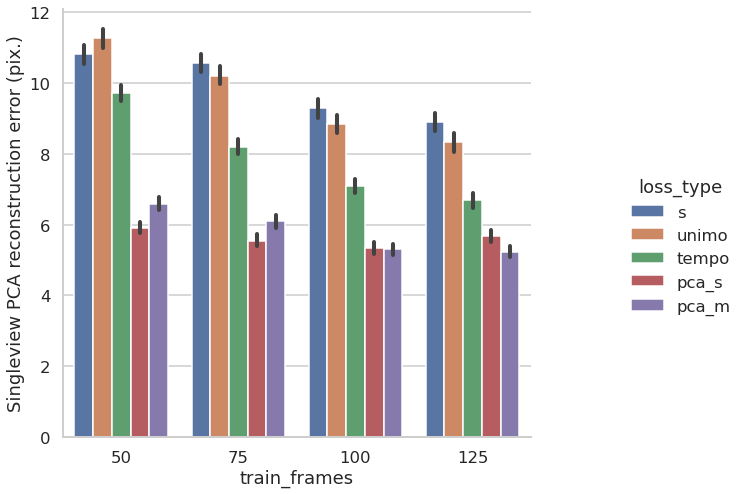

In [54]:
#have multiple columns
sns.set(context='talk', style='whitegrid', font_scale=1, rc = {'figure.figsize':(20,40)})
eval_mode = 'test'
saving_format = 'eps'
y_label = "Singleview PCA reconstruction error (pix.)"
hue_order = ['s', 'unimo', 'tempo', 'pca_s', 'pca_m']
num_losses_to_plot = 20 #len(cols_collected) # can exclude vals here
# average over keypoints and frames
df_tmp_ = df_tmp[df_tmp.eval_mode==eval_mode]
g = sns.catplot(
    data=df_tmp_, x='train_frames', hue="loss_type", y='value', kind='bar', hue_order=hue_order
)
# for ax in g.axes:
#     plt.setp(ax.get_yticklabels(), visible=True, rotation=None)
#g.set_xticklabels(rotation=80, ha='center')
# plt.title("train frames: {}, metric: {}, {} data".format(train_frames, to_compute, eval_mode))
plt.ylabel("{}".format(y_label))
plt.gcf().set_size_inches(12, 8)
plt.savefig('/home/jovyan/figs/{}_{}_{}_losses.{}'.format(to_compute, eval_mode, y_label, saving_format))

Loop over train_frames. Loop over all combos for a giving number of train frames.

In [56]:
save_dir = "/home/jovyan/lightning-pose"
loss_types = [["temporal","unimodal_mse"],["temporal","pca_multiview"],["temporal","unimodal_mse","pca_multiview"], \
    ["unimodal_mse","pca_multiview"], ["pca_singleview","unimodal_mse"],["pca_singleview","temporal"], \
        ["pca_singleview","pca_multiview"],["pca_singleview","unimodal_mse","temporal"],["pca_singleview","unimodal_mse","pca_multiview"],["pca_singleview","unimodal_mse","pca_multiview","temporal"]] # TODO: add ["pca_singleview"] TODO: order matters
print(len(loss_types)) # should be 11 but it's 10. seems like unimodal+pca_singleview is missing
log_weight_list = [] # TODO: order matters
model_names = ["train_frames_sweep"]*len(loss_types)
supervised_model_name = model_names[0] # they all have the same name
train_frames_list = [50,75,100,125]
model_type = "heatmap"
handlers = []
name_strs_to_plot = []
for tr_fr_idx, train_frames in enumerate(train_frames_list):
    for loss_idx, loss in enumerate(loss_types):
        print("==========================")
        print("Searching for train_frames: {}, loss_type: {}...".format(train_frames, loss))
        # TODO: multi-loss version below, if needed
        loss_str = '+'.join([l[:5] for l in loss] if len(loss)>0 else 's')
        # name_strs_to_plot = ['+'.join([l[:5] for l in loss]) if len(loss)>0 else 's' for loss in loss_types]
        name_str = '*'.join([loss_str, str(train_frames)])
        print("name_str: {}".format(name_str)) # TODO: just for single losses now
        name_strs_to_plot.append(name_str) 
        model_cfg = cfg.copy()
        model_cfg.training.train_frames = train_frames
        model_cfg.model.losses_to_use = loss # assume loss is already a list, [] if supervised
        model_cfg.model.model_name = model_names[loss_idx]
        model_cfg.model.model_type = model_type
        # specific arguments to "train_frames_sweep" models. TODO: change if needed
        model_cfg.training.train_prob=0.2
        model_cfg.training.val_prob=0.2
        model_cfg.training.min_epochs=125
        model_cfg.training.max_epochs=2000
        if len(loss) == 0:
            # support for uniquely-named supervised models
            model_cfg.model.model_name = supervised_model_name
        else:
            # loop over the sub losses
            if len(log_weight_list)>0:
                for sub_loss_idx,sub_loss in enumerate(loss):
                    model_cfg.losses[sub_loss].log_weight = log_weight_list[loss_idx][sub_loss_idx]
        
        try:
            handlers.append(ModelHandler(save_dir, model_cfg, verbose=False))
            print("Found: {}".format(model_cfg.model.model_name))
            print("In: {}".format(handlers[-1].model_dir))
        except FileNotFoundError:
            print('did not find %s model for train_frames=%i' % (loss, train_frames))
            continue
# report on the models found
print("==========================")
print("Found {} models out of {}.".format(len(handlers), len(train_frames_list)*len(loss_types)))

10
Searching for train_frames: 50, loss_type: ['temporal', 'unimodal_mse']...
name_str: tempo+unimo*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/21
Searching for train_frames: 50, loss_type: ['temporal', 'pca_multiview']...
name_str: tempo+pca_m*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/26
Searching for train_frames: 50, loss_type: ['temporal', 'unimodal_mse', 'pca_multiview']...
name_str: tempo+unimo+pca_m*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/31
Searching for train_frames: 50, loss_type: ['unimodal_mse', 'pca_multiview']...
name_str: unimo+pca_m*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/36
Searching for train_frames: 50, loss_type: ['pca_singleview', 'unimodal_mse']...
name_str: pca_s+unimo*50
Found: train_frames_sweep
In: /home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/4
Searching for

In [57]:
# Now for each model in a given training frame class, compute RMSE
pca_loss = None
data_module = None
to_compute = 'rmse'
for hand_idx, handler in enumerate(handlers):
    print(hand_idx)
    print("name: {}".format(handler.cfg.model.model_name))
    print("losses_to_use: {}".format(handler.cfg.model.losses_to_use))
    print(handler.model_dir)
    try:
        result = handler.compute_metric(
            to_compute, 'predictions.csv',
            keypoints_true=keypoints_gt, pca_loss_obj=pca_loss, datamodule=data_module)
    except FileNotFoundError:
        print('could not find model predictions')
        continue
    for b, bodypart in enumerate(keypoint_names):
        metrics_collected[bodypart].append(result[:, b])

0
name: train_frames_sweep
losses_to_use: ['temporal', 'unimodal_mse']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/21
Metric: rmse
Computing RMSE...
1
name: train_frames_sweep
losses_to_use: ['temporal', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/26
Metric: rmse
Computing RMSE...
2
name: train_frames_sweep
losses_to_use: ['temporal', 'unimodal_mse', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/31
Metric: rmse
Computing RMSE...
3
name: train_frames_sweep
losses_to_use: ['unimodal_mse', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-04-02/00-31-26/36
Metric: rmse
Computing RMSE...
4
name: train_frames_sweep
losses_to_use: ['pca_singleview', 'unimodal_mse']
/home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/4
Metric: rmse
Computing RMSE...
5
name: train_frames_sweep
losses_to_use: ['pca_singleview', 'temporal']
/home/jovyan/lightning-pose/multirun/2022-04-02/13-32-43/8
Metric: rmse
Computing RMSE...

In [59]:
# TODO: currently ignorant of the train_frames. either fix here or above.               
results_df = []
for bodypart in keypoint_names:
    dict_tmp = {
        'bodypart': bodypart,
        #'rng_seed': rng_seed,
        'eval_mode': handlers[-1].pred_df.iloc[:, -1].to_numpy(),
        'img_file': csv_data.iloc[:, 0], # TODO: fix, this is wrong. should be a str not a float
    }
    for col_name, metric in zip(name_strs_to_plot, metrics_collected[bodypart]):
        dict_tmp[col_name] = metric
    results_df.append(pd.DataFrame(dict_tmp))

results_df = pd.concat(results_df)

In [61]:
results_df.head()

,bodypart,eval_mode,img_file,tempo+unimo*50,tempo+pca_m*50,tempo+unimo+pca_m*50,unimo+pca_m*50,pca_s+unimo*50,pca_s+tempo*50,pca_s+pca_m*50,...,tempo+unimo*125,tempo+pca_m*125,tempo+unimo+pca_m*125,unimo+pca_m*125,pca_s+unimo*125,pca_s+tempo*125,pca_s+pca_m*125,pca_s+unimo+tempo*125,pca_s+unimo+pca_m*125,pca_s+unimo+pca_m+tempo*125
0,paw1LH_top,unused,barObstacleScaling1/img1.png,18.665041,25.716328,29.095648,13.086377,35.767075,40.445728,9.071325,...,23.836328,61.937030,13.579142,10.702983,10.109796,6.942181,55.070242,7.568261,109.156924,116.859575
1,paw1LH_top,validation,barObstacleScaling1/img2.png,27.270346,45.393024,4.324686,11.251966,7.671335,7.156842,5.996880,...,28.929875,30.528513,68.564993,36.548762,20.147083,12.016339,32.601808,15.349059,47.109919,36.893723
2,paw1LH_top,test,barObstacleScaling1/img3.png,27.277538,10.173132,25.928988,9.610102,62.957268,56.440548,2.589767,...,7.175273,1.819079,2.329572,1.756647,6.233535,57.651574,13.788527,1.731280,1.709212,2.164637
3,paw1LH_top,test,barObstacleScaling1/img4.png,53.127167,3.053695,5.623690,8.254601,16.647322,3.711756,2.177805,...,5.103749,2.953940,2.746120,3.303396,2.316468,3.869006,4.372636,2.370693,1.902437,1.173159
4,paw1LH_top,test,barObstacleScaling1/img5.png,3.977809,3.446553,1.805771,3.461076,1.670208,1.347818,6.188214,...,5.631472,6.143798,5.575036,7.170720,8.486813,9.732529,6.420266,8.307228,7.989138,7.546980


In [62]:
# go ahead and separate the names
df_tmp = pd.melt(
    results_df, 
    id_vars=['bodypart', 'img_file', 'eval_mode'],
    value_vars=name_strs_to_plot,
)
def add_loss_name_col(row):
    return '_'.join(row['variable'].split('_')[:-1])
def add_loss_val_col(row):
    return row['variable'].split('_')[-1]
df_tmp['loss'] = df_tmp.apply(add_loss_name_col, axis=1) # TODO: not doing anything

In [63]:
df_tmp["loss_type"] = df_tmp.variable.str.split('*').str[0]
df_tmp["train_frames"] = df_tmp.variable.str.split('*').str[1]

In [64]:
df_tmp.head()

,bodypart,img_file,eval_mode,variable,value,loss,loss_type,train_frames
0,paw1LH_top,barObstacleScaling1/img1.png,unused,tempo+unimo*50,18.665041,,tempo+unimo,50
1,paw1LH_top,barObstacleScaling1/img2.png,validation,tempo+unimo*50,27.270346,,tempo+unimo,50
2,paw1LH_top,barObstacleScaling1/img3.png,test,tempo+unimo*50,27.277538,,tempo+unimo,50
3,paw1LH_top,barObstacleScaling1/img4.png,test,tempo+unimo*50,53.127167,,tempo+unimo,50
4,paw1LH_top,barObstacleScaling1/img5.png,test,tempo+unimo*50,3.977809,,tempo+unimo,50


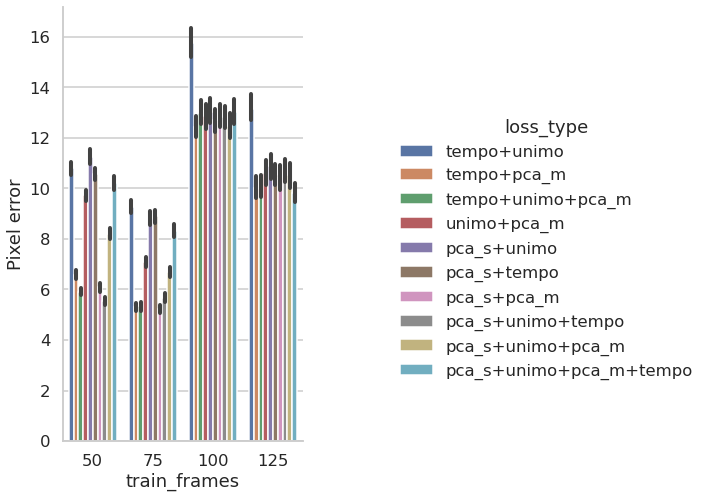

In [69]:
sns.set(context='talk', style='whitegrid', font_scale=1, rc = {'figure.figsize':(20,40)})
eval_mode = 'test'
saving_format = 'eps'
y_label = "Pixel error"
hue_order = None # ['s', 'unimo', 'tempo', 'pca_s', 'pca_m']
num_losses_to_plot = 20 #len(cols_collected) # can exclude vals here
# average over keypoints and frames
df_tmp_ = df_tmp[df_tmp.eval_mode==eval_mode]
g = sns.catplot(
    data=df_tmp_, x='train_frames', hue="loss_type", y='value', kind='bar', hue_order=hue_order
)
# for ax in g.axes:
#     plt.setp(ax.get_yticklabels(), visible=True, rotation=None)
#g.set_xticklabels(rotation=80, ha='center')
# plt.title("train frames: {}, metric: {}, {} data".format(train_frames, to_compute, eval_mode))
plt.ylabel("{}".format(y_label))
plt.gcf().set_size_inches(12, 8)
#plt.savefig('/home/jovyan/figs/{}_{}_{}_losses.{}'.format(to_compute, eval_mode, y_label, saving_format))

40

40